# Z3 SAT Exercises

> Before trying to solve the exercises contained in this notebook, the reader is suggested to have gained experience with the tool through the `Tutorial.ipynb` notebook.

In [1]:
!pip3 install z3-solver

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [159]:
from itertools import combinations
from z3 import *
from utils import *
import numpy as np

import time

## Useful contraints

In [2]:
def at_least_one(bool_vars):
    return Or(bool_vars)

def at_most_one(bool_vars):
    return [Not(And(pair[0], pair[1])) for pair in combinations(bool_vars, 2)]

def exactly_one(bool_vars):
    return at_most_one(bool_vars) + [at_least_one(bool_vars)]

## VLSI

In [109]:
# VLSI instances

# Toy case
instance_toy = {
    "w": 9,
    "n": 5,
    "points" : np.array([(3,3),(2,4),(2,8),(3,9),(4,12)],\
                        dtype=[('w','i4'),('h','i4')])
}

In [174]:
def write_file(w, n, x, y, p_x_sol, p_y_sol, rot_sol, length, elapsed_time,  out_file):
    with open(out_file, 'w+') as f_out:
        f_out.write('{} {}\n'.format(w, length))
        f_out.write('{}\n'.format(n))

        for i in range(n):
            is_rotated = "R" if rot_sol[i] else ""
            f_out.write('{} {} {} {} {}\n'.format(x[i], y[i], p_x_sol[i], p_y_sol[i], is_rotated))
        f_out.write(f'{elapsed_time :.2f}')

def show(l,lw=1.5):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))    
    dim_img_in=(np.sum([i[0] for i in l[1:]])+2*len(l)-4, max([i[1] for i in l[1:]]))
    img_in=np.zeros(shape=dim_img_in)
    pos=0
    c=0
    for i in l[1:]:
        c-=1
        i[2]-=1
        i[3]-=1
        img_in[pos:pos+i[0], 0:i[1]]=c
        pos+=i[0]+2
    
    ax1.imshow(np.transpose(img_in), cmap='terrain')
    ax1.set_xticks(np.arange(dim_img_in[0]+1)-0.5)
    ax1.set_xticklabels([])
    ax1.set_yticks(np.arange(dim_img_in[1]+1)-0.5)
    ax1.set_yticklabels([])
    ax1.set_xlim(-0.5,dim_img_in[0]-0.5)
    ax1.set_ylim(-0.5,dim_img_in[1]-0.5)
    ax1.grid(color='k', linestyle='-', linewidth=lw)
        
    dim_img_out=[l[0][0], l[0][1]+1]
    img_out=np.zeros(shape=dim_img_out)
    c=0
    
    for i in l[1:]:
        c-=1
        img_out[i[2]:i[2]+i[0],i[3]:i[3]+i[1]]=c        

    ax2.imshow(np.transpose(img_out), cmap='terrain')
    ax2.set_xticks(np.arange(dim_img_out[0]+1)-0.5)#,labels=[])
    ax2.set_xticklabels([])
    ax2.set_yticks(np.arange(dim_img_out[1]+1)-0.5)#,labels=[])
    ax2.set_yticklabels([])
    ax2.set_xlim(-0.5,dim_img_out[0]-0.5)
    ax2.set_ylim(-0.5,dim_img_out[1]-0.5)
    ax2.grid(color='k', linestyle='-', linewidth=lw)
    
    plt.show()

def model_to_coordinates(model, p, w, l, n, r=None):
    # Create solution array
    solution = np.array([[[is_true(model[p[i][j][k]]) for k in range(n)] for j in range(w)] for i in range(l)])

    p_x_sol = []
    p_y_sol = []
    rot_sol = [False for i in range(n)]

    for k in range(n):
        y_ids, x_ids = solution[:, :, k].nonzero()
        x = np.min(x_ids)
        y = np.min(y_ids)
        p_x_sol.append(x)
        p_y_sol.append(y)
        if r is not None:
            rot_sol[k] = is_true(model[r[k]])
    return p_x_sol, p_y_sol, rot_sol

In [164]:
def vlsi_sat(instance):
    
    points = instance['points']
    
    w = instance['w']
    max_h = sum(points['h'])
    n = instance['n']
    
    # For each cell, n variables that determine wich circuit must be assigned.
    c = [[[Bool(f"v_{i}_{j}_{k}") for k in range(n)] for j in range(w)] for i in range(max_h)]

    # Length of the plate to minimize (one-hot representation)
    l = [Bool(f"l_{i}") for i in range(max_h)]
    
    s = Solver()

    # CONSTRAINT 1
    # A cell has at most one value
    for i in range(max_h):
        for j in range(w):
            s.add(at_most_one(c[i][j]))

    # 2 - CONSTRAINT
    # Iterate over all the n circuits
    exactly_one_circuit_positioning = []
    for k in range(n):
        x_k = points['w'][k]
        y_k = points['h'][k]

        # clause containing all possible positions of each circuit into the plate
        all_circuit_positions = []

        # Iterate over all the coordinates where the circuit can fit
        for i in range(max_h - y_k + 1):
            for j in range(w - x_k + 1):

                # all cells corresponding to the circuit position
                circuit_positioning = []

                # Iterate over the cells of circuit's patch
                for oy in range(max_h):
                    for ox in range(w):
                        if i <= oy < i + y_k and j <= ox < j + x_k:
                            circuit_positioning.append(c[oy][ox][k])
                        else:
                            circuit_positioning.append(Not(c[oy][ox][k]))

                all_circuit_positions.append(And(circuit_positioning))

        # Exactly one
        s.add(exactly_one(all_circuit_positions))
    
    # 3 - CONSTRAINT
    # One-hot encoding of the length
    s.add(exactly_one([l[i] for i in range(max_h)]))

    # 4 - CONSTRAINT
    # Compute the length consistent w.r.t. the actual circuits positioning
    s.add([l[i] == And([Or(list(np.concatenate(c[i]).flat))] + [Not(Or(list(np.concatenate(c[j]).flat))) for j in range(i + 1, max_h)])
                                   for i in range(max_h)])

    # 5 - CONSTRAINT
    # the circuit whose height is the maximum among all circuits is put in the left-bottom corner
    max_y = np.argmax(points['h'])
    s.add([
        And([c[i][j][k] if k == max_y else Not(c[i][j][k]) for k in range(n) for j in range(points['w'][max_y]) for i in
             range(points['h'][max_y])])
        ])

    start_time = time.time()
    solution_found = False
    length_sol = 0
    
    while s.check() == sat:
        model = s.model()
        #print(model[len(model)-1], " : ", model[model[len(model)-1]])
        for k in range(max_h):
            #print(model[k], " : ", model[model[k]])
            
            #if model.evaluate(l[k]) is True:            
            if model.evaluate(l[k]) == True:            
                print(l[k], " : ", model.evaluate(l[k]))
                print('k', k)
                length_sol = k

        # prevent next model from using the same assignment as a previous model
        s.add(at_least_one([l[i] for i in range(length_sol)]))
        solution_found = True
        
    if solution_found:
        length_sol += 1
        elapsed_time = time.time() - start_time
        print(f"The minimal length is {length_sol}")
        
        p_x_sol, p_y_sol, rot_sol = model_to_coordinates(model, c, w, length_sol, n)

        write_file(w, n, points['w'], points['h'], p_x_sol, p_y_sol, rot_sol, length_sol, elapsed_time, 'out.txt')
    else:
        print("Failed to solve")


In [165]:
# Select the instance you want to solve
instance = instance_toy

In [166]:
%%time
vlsi_sat(instance)

l_34  :  True
k 34
l_33  :  True
k 33
l_32  :  True
k 32
l_29  :  True
k 29
l_28  :  True
k 28
l_23  :  True
k 23
l_17  :  True
k 17
l_16  :  True
k 16
l_11  :  True
k 11
The minimal length is 12
Wall time: 36.5 s


[(3,  3) (2,  4) (2,  8) (3,  9) (4, 12)]
[(7, 10), (5, 9), (5, 1), (7, 1), (1, 1)]
[[9, 12], [3, 3, 7, 10], [2, 4, 5, 9], [2, 8, 5, 1], [3, 9, 7, 1], [4, 12, 1, 1]]


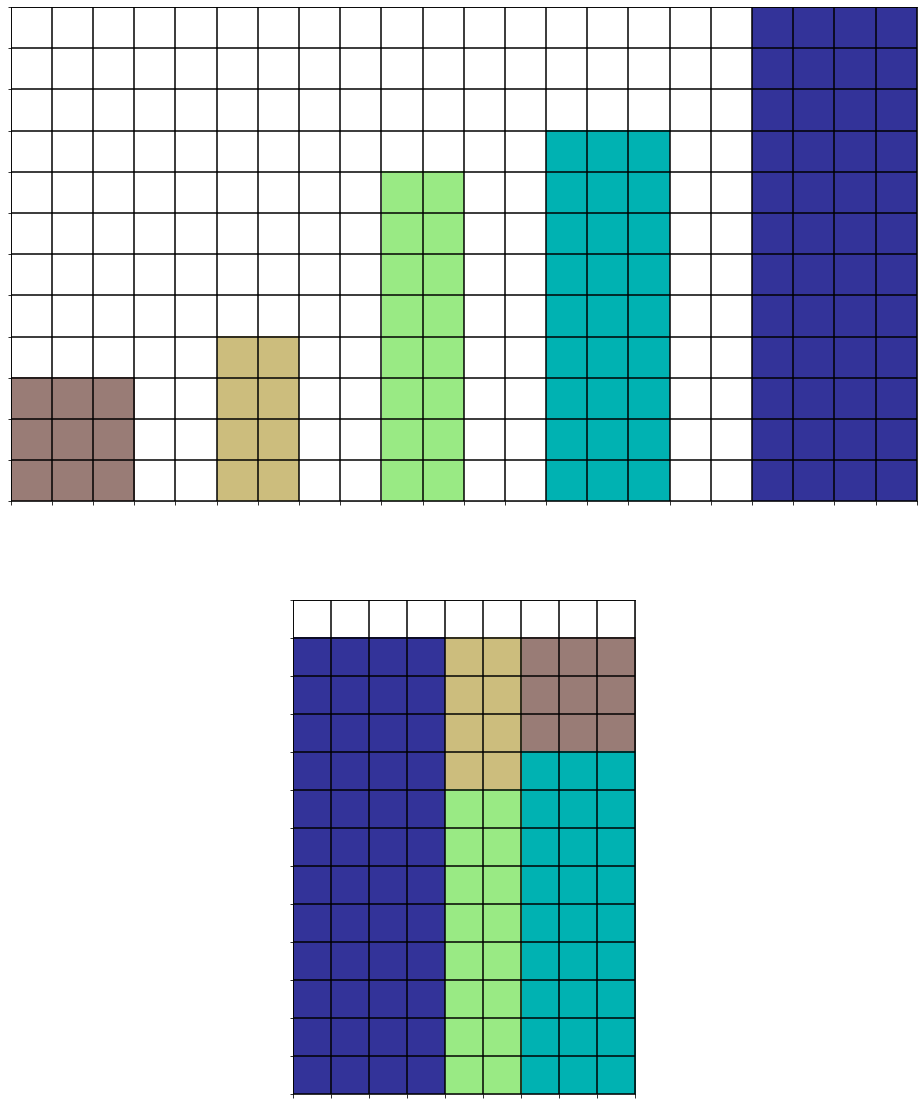

In [198]:
with open('out.txt', "r") as file:  # Use file to refer to the file object
    # Read the first line which contains the width and the minimal height of the silicon plate
    first_line = file.readline().strip().split(" ")

    width = int(first_line[0])
    height = int(first_line[1])

    # Read the second line which contains the number of necessary circuits
    n_circuits = int(file.readline().strip())

    # Read all the remaining lines which contains the horizontal and vertical dimension of the i-th circuit
    # and its bottom left corner coordinate
    remaining_lines = file.readlines()

    # To remove empty lines
    remaining_lines = [line.strip() for line in remaining_lines if line.strip()]

    # To remove lines like === or ----
    remaining_lines = [line for line in remaining_lines if ("=" not in line) and ('-' not in line)]

    circuits = []
    solution = {'corners': [], 'rotation': []}

    for i in range(n_circuits):
        line = remaining_lines[i]
        line = line.split()
        circuits.append((int(line[0]), int(line[1])))
        solution['corners'].append((int(line[2]), int(line[3])))
        solution['rotation'].append(True if len(line) == 5 else False)

# Solution
sol = {
    "w": width,
    "h": height,
    "n": n_circuits,
    "points" : np.array(circuits,\
                        dtype=[('w','i4'),('h','i4')])
}


print(sol['points'])
print([(x+1,y+1) for (x,y) in solution['corners']])
l = [[sol['w'], sol['h']]]

a = sol['points']
b = solution['corners']

for i in range(len(a)):
    l.append([a[i][0],a[i][1],b[i][0]+1,b[i][1]+1])

print(l)
show(l)